In [83]:
%matplotlib inline

import matplotlib.pyplot as plt
import hdf5_getters
import sqlite3 as sq
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
import urllib.request
import json

In [28]:
h5 = hdf5_getters.open_h5_file_read("TRAAAAW128F429D538.h5")
duration = hdf5_getters.get_artist_terms_weight(h5)
print(duration)


[ 1.          0.89793596  0.88426185  0.84262975  0.84256301  0.83239282
  0.82577707  0.79859195  0.7431759   0.73850237  0.72505245  0.71389955
  0.67049417  0.65697231  0.65105613  0.65105612  0.65105597  0.65105592
  0.65105547  0.65105532  0.65105508  0.65105506  0.65105461  0.65105427
  0.65105376  0.65104997  0.6364043   0.63334971  0.61973455  0.61889383
  0.61419433  0.59579116  0.56220197  0.55067233  0.52897541  0.49021215
  0.38341077]


## Additional Files

### Releases per Year per Genre

In [29]:
def db_list_tables(path):
    print ("Connecting to DB at path {}".format(path))
    conn = sq.connect(path)
    c = conn.cursor()
    
    c.execute("select sql from sqlite_master where type = 'table'")
    
    print ("Tables in database:")
    for row in c.fetchall():
        print (row)

In [30]:
path_artists_genres = os.path.join(".", "AdditionalFiles", "subset_artist_term.db")
db_list_tables(path_artists_genres)

path_artists_similarity = os.path.join(".", "AdditionalFiles", "subset_artist_similarity.db")
db_list_tables(path_artists_similarity)

path_track_metadata = os.path.join(".", "AdditionalFiles", "subset_track_metadata.db")
db_list_tables(path_track_metadata)

Connecting to DB at path .\AdditionalFiles\subset_artist_term.db
Tables in database:
('CREATE TABLE artists (artist_id text PRIMARY KEY)',)
('CREATE TABLE terms (term text PRIMARY KEY)',)
('CREATE TABLE artist_term (artist_id text, term text, FOREIGN KEY(artist_id) REFERENCES artists(artist_id), FOREIGN KEY(term) REFERENCES terms(term) )',)
('CREATE TABLE mbtags (mbtag text PRIMARY KEY)',)
('CREATE TABLE artist_mbtag (artist_id text, mbtag text, FOREIGN KEY(artist_id) REFERENCES artists(artist_id), FOREIGN KEY(mbtag) REFERENCES mbtags(mbtag) )',)
Connecting to DB at path .\AdditionalFiles\subset_artist_similarity.db
Tables in database:
('CREATE TABLE artists (artist_id text PRIMARY KEY)',)
('CREATE TABLE similarity (target text, similar text, FOREIGN KEY(target) REFERENCES artists(artist_id), FOREIGN KEY(similar) REFERENCES artists(artist_id) )',)
Connecting to DB at path .\AdditionalFiles\subset_track_metadata.db
Tables in database:
('CREATE TABLE songs (track_id text PRIMARY KEY, tit

In [31]:
# get number of songs per year per artist
conn = sq.connect(path_track_metadata)
c = conn.cursor()
c.execute("""SELECT artist_id, artist_name, year, count(*) as cnt
            FROM songs
            GROUP BY artist_id, year
            Having year>0
            ORDER BY year""")

res_art_song_year = c.fetchall()
for i in range(10):
    print (res_art_song_year[i])

('ARE36MM1187B991E50', 'Blind Lemon Jefferson', 1926, 2)
('ARE36MM1187B991E50', 'Blind Lemon Jefferson', 1927, 1)
('ARRU9GR1187FB43F56', 'Blind Willie McTell', 1927, 1)
('ARWQ2DR1187B98FF28', 'Ma Rainey', 1927, 1)
('ARTDUXM1187B9899ED', 'Charley Patton', 1929, 1)
('ARE2QID1187B98FA19', 'Sleepy John Estes', 1930, 1)
('ARTDUXM1187B9899ED', 'Charley Patton', 1930, 1)
('ARTDUXM1187B9899ED', 'Charlie Patton', 1934, 1)
('ARE2QID1187B98FA19', 'Sleepy John Estes', 1935, 2)
('AR9HABI1187FB3ACAA', 'Red Foley', 1936, 1)


#### Genre from EchoNest

In [32]:
#get mapping artist genre
conn = sq.connect(path_artists_genres)
c = conn.cursor()
c.execute("""SELECT artist_id, term
              FROM artist_term""")

res_art_genre = c.fetchall()
for i in range(5):
    print (res_art_genre[i])

('AR009211187B989185', 'lovers rock')
('AR009211187B989185', 'reggae')
('AR009211187B989185', 'roots reggae')
('AR009211187B989185', 'uk garage')
('AR009211187B989185', 'ballad')


In [33]:
# merge lists: count number of songs per genre (if artist has 2 gernres, count for each one)
df_art_song_year = pd.DataFrame(res_art_song_year)
df_art_song_year.columns = ["artist_id", "artist_name", "year", "tracks"]
df_art_song_year.head()

,artist_id,artist_name,year,tracks
0,ARE36MM1187B991E50,Blind Lemon Jefferson,1926,2
1,ARE36MM1187B991E50,Blind Lemon Jefferson,1927,1
2,ARRU9GR1187FB43F56,Blind Willie McTell,1927,1
3,ARWQ2DR1187B98FF28,Ma Rainey,1927,1
4,ARTDUXM1187B9899ED,Charley Patton,1929,1


In [34]:
df_art_genre = pd.DataFrame(res_art_genre)
df_art_genre.columns = ["artist_id", "genre"]
df_art_genre.head()

,artist_id,genre
0,AR009211187B989185,lovers rock
1,AR009211187B989185,reggae
2,AR009211187B989185,roots reggae
3,AR009211187B989185,uk garage
4,AR009211187B989185,ballad


In [35]:
df_art_song_year_genre = pd.merge(df_art_song_year, df_art_genre, on="artist_id")

df_song_year_genre = df_art_song_year_genre.drop(df_art_song_year_genre.columns[:2], axis=1)
print (df_song_year_genre.shape)
df_song_year_genre.head()

(109034, 3)


,year,tracks,genre
0,1926,2,country blues
1,1926,2,delta blues
2,1926,2,texas blues
3,1926,2,blues
4,1926,2,louisiana blues


In [36]:
df_song_year_genre.sort_values(["tracks"], ascending=False).head()

,year,tracks,genre
98889,2006,8,reggae
98901,2006,8,soft
98893,2006,8,female vocalist
98894,2006,8,funk
98895,2006,8,singer-songwriter


#### Genre from mb

In [37]:
#get mapping artist genre
conn = sq.connect(path_artists_genres)
c = conn.cursor()
c.execute("""SELECT artist_id, mbtag
              FROM artist_mbtag""")

res_art_genre = c.fetchall()
for i in range(5):
    print (res_art_genre[i])

('AR00A6H1187FB5402A', 'detroit')
('AR00A6H1187FB5402A', 'punk')
('AR00A6H1187FB5402A', 'michigan')
('AR00A6H1187FB5402A', 'usa')
('AR01VU31187B997DA0', 'hard rock')


In [38]:
# merge lists: count number of songs per genre (if artist has 2 gernres, count for each one)
df_art_song_year = pd.DataFrame(res_art_song_year)
df_art_song_year.columns = ["artist_id", "artist_name", "year", "tracks"]
df_art_song_year.head()

,artist_id,artist_name,year,tracks
0,ARE36MM1187B991E50,Blind Lemon Jefferson,1926,2
1,ARE36MM1187B991E50,Blind Lemon Jefferson,1927,1
2,ARRU9GR1187FB43F56,Blind Willie McTell,1927,1
3,ARWQ2DR1187B98FF28,Ma Rainey,1927,1
4,ARTDUXM1187B9899ED,Charley Patton,1929,1


In [39]:
df_art_genre = pd.DataFrame(res_art_genre)
df_art_genre.columns = ["artist_id", "genre"]
df_art_genre.head()

,artist_id,genre
0,AR00A6H1187FB5402A,detroit
1,AR00A6H1187FB5402A,punk
2,AR00A6H1187FB5402A,michigan
3,AR00A6H1187FB5402A,usa
4,AR01VU31187B997DA0,hard rock


In [40]:
df_art_song_year_genre = pd.merge(df_art_song_year, df_art_genre, on="artist_id")

df_song_year_genre = df_art_song_year_genre.drop(df_art_song_year_genre.columns[:2], axis=1)
print (df_song_year_genre.shape)
df_song_year_genre.head()

(8366, 3)


,year,tracks,genre
0,1926,2,blues
1,1926,2,american
2,1927,1,blues
3,1927,1,american
4,1972,1,blues


In [41]:
df_song_year_genre.sort_values(["tracks"], ascending=False).head()

,year,tracks,genre
7994,2006,8,soul and reggae
3982,1992,5,usa
3976,1992,5,grunge
6925,2002,5,rock and indie
3984,1992,5,american


mb has less unique tags.

# Try to iterate over all songs

For the moment we try some methods on the local set we have, then it'll be run on cluster, but to test it is much easier locally on the subset

In [42]:
import os
import glob
def count_all_files(basedir,ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [43]:
local_path = 'C:/Users/Max-Pc/Downloads/millionsongsubset_full/MillionSongSubset/data'
count_all_files(local_path)

10000

In [44]:
def get_all_titles(basedir,ext='.h5') :
    titles = []
    iteration = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            titles.append( hdf5_getters.get_title(h5))
            h5.close()
            iteration+=1
            if(iteration%1000== 0):
                print(iteration)
    return titles

In [45]:
def get_all_interesting_data(basedir,ext='.h5') :
    datas = []
    iteration = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            oneSongData = []
            h5 = hdf5_getters.open_h5_file_read(f)
            oneSongData.append( hdf5_getters.get_artist_id(h5))
            oneSongData.append(hdf5_getters.get_artist_name(h5))
            oneSongData.append(hdf5_getters.get_year(h5))
            oneSongData.append(hdf5_getters.get_danceability(h5)) #always zero
            oneSongData.append(hdf5_getters.get_duration(h5))
            oneSongData.append(hdf5_getters.get_song_hotttnesss(h5))
            oneSongData.append(hdf5_getters.get_title)
            oneSongData.append(hdf5_getters.get_tempo(h5))
            oneSongData.append(hdf5_getters.get_time_signature(h5))
            oneSongData.append(hdf5_getters.get_time_signature_confidence(h5))
            oneSongData.append(hdf5_getters.get_artist_mbtags(h5))
            oneSongData.append(hdf5_getters.get_artist_terms(h5))
            oneSongData.append(hdf5_getters.get_artist_location(h5))
            oneSongData.append(hdf5_getters.get_artist_latitude(h5))
            oneSongData.append(hdf5_getters.get_artist_longitude(h5))
            h5.close()
            iteration+=1
            if(iteration%1000== 0):
                print(iteration)
            datas.append(oneSongData)
    return datas

In [46]:
datas = get_all_interesting_data(local_path)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [47]:

df = pd.DataFrame(datas,columns=['ArtistID','ArtistName','SongYear','SongDanceability','Duration','SongHotness','SongTitle','SongTempo','SongTimeSignature','SongTimeSignatureConfidence','ArtistMbtags','ArtistTerms','ArtistLocation','ArtistLatitude','ArtistLongitude'])

In [57]:
df = df[df['SongYear']>0]
df.describe()

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude
count,4680.000000,4680.0,4680.000000,3064.000000,4680.000000,4680.000000,4680.000000,1825.000000,1825.000000
mean,1997.232051,0.0,238.781146,0.444377,125.163716,3.586111,0.510216,37.501760,-61.772744
std,11.686691,0.0,101.345438,0.222470,35.272251,1.240247,0.375063,16.273911,51.525675
min,1926.000000,0.0,1.044440,0.000000,0.000000,0.000000,0.000000,-41.280540,-155.434140
25%,1993.000000,0.0,181.152200,NaN,98.698500,3.000000,0.089000,NaN,NaN
50%,2001.000000,0.0,227.382400,NaN,122.226500,4.000000,0.553000,NaN,NaN
75%,2006.000000,0.0,278.406080,NaN,146.572000,4.000000,0.868000,NaN,NaN
max,2010.000000,0.0,1598.197100,1.000000,258.677000,7.000000,1.000000,69.651020,174.767140


## Observation about DATAS
We drop everything with no date ( or date =0), we actually see that there is no song danceability here for the substet ( double check with full dataset) 
For the duration, there is a song with duration = 1s , maybe take only ones with 60s and more, we look at song with more than  minutes, and ones with less than minutes, we consider dropping them.

For songHotness plot and should keep NaN for the moment, or at leasdt put them at 0

For Tempo, some really high , really few at 0, look at this a little more maybe

For Songsig , discrete number of beats by bar, the confidence is also plotted , lot of 0 and 1 but same depends on the question we ask ourselves.

For the tags, mbtags are not that specifics and lot are empty, while echonest terms are really specifics , we have found a hierachy for genre from here : http://musicmap.info/master-genrelist.json
Look really nice and can group in more categorical genre.

Popularity on spotify can be fetched ( between 0-100), number not limited, just get a  429 code return and need to wait a dynamically assigned time. We can also try to fetch all the ID's in 1 request.


(35, 15)
(73, 15)


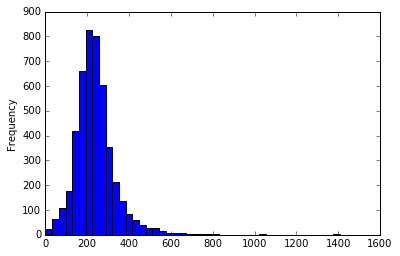

In [72]:
df.Duration.plot(kind='hist',bins=50)
print(df[df['Duration']>600].shape)
print(df[df['Duration']<60].shape)

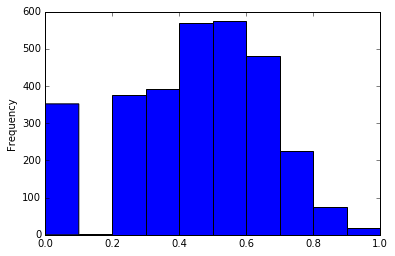

In [73]:
df.SongHotness.plot(kind='hist')

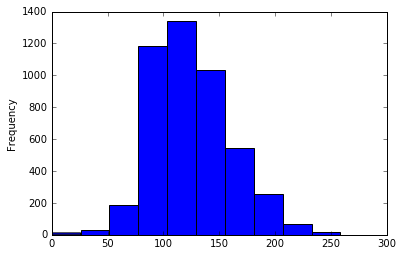

In [74]:
df.SongTempo.plot(kind='hist')

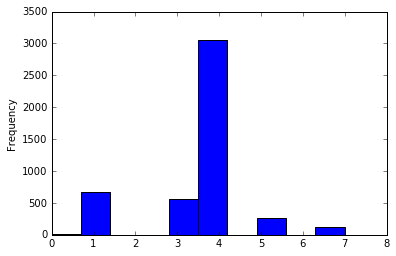

In [75]:
df.SongTimeSignature.plot(kind='hist')

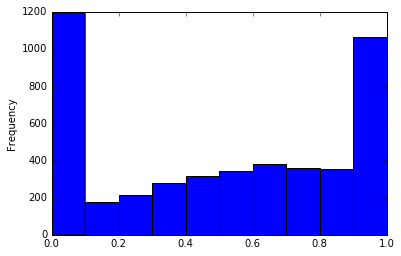

In [76]:
df.SongTimeSignatureConfidence.plot(kind='hist')

In [81]:
df.ArtistTerms

1       [b'blue-eyed soul', b'pop rock', b'blues-rock'...
3       [b'pop rock', b'new wave', b'dance rock', b'ro...
4       [b'pop punk', b'ska punk', b'breakcore', b'alt...
8       [b'new wave', b'progressive rock', b'space roc...
14      [b'quiet storm', b'soft rock', b'pop', b'urban...
15      [b'country rock', b'heartland rock', b'pop roc...
18      [b'hard rock', b'heavy metal', b'blues-rock', ...
23      [b'math-core', b'grindcore', b'hardcore punk',...
24      [b'pop rock', b'soft rock', b'blues-rock', b'd...
27      [b'filk', b'comedy', b'spoken word', b'country...
28      [b'latin jazz', b'jazz funk', b'boogaloo', b's...
29      [b'jump blues', b'east coast blues', b'piano b...
30      [b'soul jazz', b'future jazz', b'smooth jazz',...
32      [b'doo-wop', b'ballad', b'pop rock', b'rock st...
33      [b'classic country', b'motown', b'oldies', b'r...
35      [b'charanga', b'salsa', b'latin jazz', b'rumba...
40      [b'gothic metal', b'deathrock', b'horror punk'...
41      [b'ska

In [93]:
with urllib.request.urlopen('http://musicmap.info/master-genrelist.json') as url:
    data = json.loads(url.read().decode())